<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG596_2021_SUMMER/blob/main/get_dbt_data_phase2_ipyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%load_ext autoreload
#%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

#imports needed for dbtex function
print('---dbtex installs---')
!pip3 install -q pylibjpeg  #for dbtex
!pip3 install -q python-gdcm
!pip3 install -q pylibjpeg-libjpeg 
!pip3 install -q pylibjpeg-openjpeg
!pip3 install -q Pillow


import PIL
import pylibjpeg

#
# Load data from google drive
#

drive.mount('/content/gdrive')




     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 132 kB 5.1 MB/s 
---dbtex installs---
     |████████████████████████████████| 884 kB 7.8 MB/s 
     |████████████████████████████████| 3.6 MB 50.4 MB/s 
     |████████████████████████████████| 9.4 MB 4.6 MB/s 
     |████████████████████████████████| 4.2 MB 5.2 MB/s 


In [2]:
'''
### set up drives for including .py files
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'BE223C_SPRING_2021/PY_FILES'
GOOGLE_DRIVE_PATH = os.path.join('/content/gdrive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time
os.environ["TZ"] = "US/Eastern"
time.tzset()

#import dbtex_dbt_data

'''

'\n### set up drives for including .py files\nGOOGLE_DRIVE_PATH_AFTER_MYDRIVE = \'BE223C_SPRING_2021/PY_FILES\'\nGOOGLE_DRIVE_PATH = os.path.join(\'/content/gdrive\', \'My Drive\', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)\nprint(os.listdir(GOOGLE_DRIVE_PATH))\nimport sys\nsys.path.append(GOOGLE_DRIVE_PATH)\n\nimport time\nos.environ["TZ"] = "US/Eastern"\ntime.tzset()\n\n#import dbtex_dbt_data\n\n'

In [2]:
#code borrowed from
#https://gist.github.com/cmarasinou/7c990a4835e80874b4de5f2433612d65
###############testing out embedded function, as .py import failing

from typing import AnyStr, BinaryIO, Optional, Union

import numpy as np
import pydicom as dicom
from skimage.exposure import rescale_intensity


def dcmread_image(
    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
    view: str,
    index: Optional[np.uint] = None,
) -> np.ndarray:
    """Read pixel array from DBT DICOM file"""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name='pillow') #pylibjpeg')
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
        print("Laterality fixed!")
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(
        pixel_array, in_range=(low, high), out_range="dtype"
    )
    return pixel_array


def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Unreliable - DICOM laterality is incorrect for some cases"""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value


def _get_image_laterality(pixel_array: np.ndarray) -> str:
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"


def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)


def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

In [3]:
'''
GET DIR LISTING----------------------------------------------------------------
'''
def get_dirs(top_dir): 
    import os

    dir_list = os.scandir(top_dir)
    directories=[]
    patient_data = {}
    for ii in dir_list:
        print('top dir is ',ii)
        if (ii.is_dir()):
            #patient ID directory
            patient_id = ii.name
            patient_data[patient_id]={}
            directories.append(ii.name)
            #get file listings for each directory found
            full_name = os.path.join(top_dir,ii.name)


            files = os.scandir(full_name)
            for patient_uid in files:
                #print('ptuid = ',patient_uid)
                pass

            if (patient_uid.is_dir()):
                #this will be the longer directory name
                #with study id
                #This will need to be tokenized to get 
                #the two fields out for info
                #--for now, keep the longer directory name
                patient_data[patient_id][patient_uid.name]={}

                exam_listings = os.scandir(os.path.join(full_name, 
                                                  patient_uid.name))
                for exam_number in exam_listings:
                    patient_data[patient_id][patient_uid.name][exam_number.name] =[]
                    #fill this in with exam dcm contents
                    dcm_list = os.listdir(os.path.join(full_name, 
                                                  patient_uid.name,
                                                  exam_number.name))
                    for dcm_file in dcm_list:
                        patient_data[patient_id][patient_uid.name][exam_number.name].append(dcm_file)

        else:
            print('*** found single file ',ii.name)

    
    return patient_data

In [4]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

In [5]:
### Main level
dataset = 0 #0=training, 1 = validation, 2 = test
if (dataset == 0):
    top_dir = '/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT' #DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT'
    p_dir = '/content/gdrive/My Drive/DBTex2'
    png_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/PNG_IMAGES'
    png_annotation_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/PNG_ANNOTATION_IMAGES'
    image_save_dir = '/content/gdrive/My Drive/DBTex2/DBTEX_PHASE2_WORKING/DICOM2RAW/TRAINING' #matrix img data
    data_dir_file = os.path.join(top_dir,'saved_directories.pckl')
    #'/content/gdrive/My Drive/BE223C_SPRING_2021/IMAGE_ARRAY'
elif (dataset == 1):
    print('Processing VALIDATION SET')
    top_dir = '/content/gdrive/My Drive/DBT_DATA/VALIDATION/manifest-1605042674814/Breast-Cancer-Screening-DBT'
    p_dir = '/content/gdrive/My Drive/DBTex2'
    png_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/PNG_IMAGES'
    png_annotation_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/PNG_ANNOTATION_IMAGES'
    image_save_dir = '/content/gdrive/My Drive/DBTex2/DBTEX_PHASE2_WORKING/DICOM2RAW/VALIDATION' #matrix img data
    #image_save_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/VALIDATION_IMG_ARRAYS' #matrix img data
    data_dir_file = os.path.join(top_dir,'saved_directories_val.pckl')
else:
    print('Missing TEST FOLDER')

use_restored_dir_list=0
data_dir_file = os.path.join(p_dir,'saved_diretories.pckl')
if (use_restored_dir_list==0):
    upper_dir =top_dir

    patient_data = get_dirs(upper_dir)
    #save the file list for use later
    print('pickling patient data folder list')
    pickle.dump(patient_data, open( data_dir_file, "wb" ),protocol=5 )

else:
    if os.path.getsize(data_dir_file) > 0:
        upper_dir = top_dir
        patient_data = pickle.load( open( data_dir_file, "rb" ) )
    else:
        print('pickle file is')



top dir is  <DirEntry 'DBT-P03902'>
top dir is  <DirEntry 'DBT-P03903'>
top dir is  <DirEntry 'DBT-P03904'>
top dir is  <DirEntry 'DBT-P03905'>
top dir is  <DirEntry 'DBT-P03906'>
top dir is  <DirEntry 'DBT-P03908'>
top dir is  <DirEntry 'DBT-P03909'>
top dir is  <DirEntry 'DBT-P03907'>
top dir is  <DirEntry 'DBT-P03912'>
top dir is  <DirEntry 'DBT-P03914'>
top dir is  <DirEntry 'DBT-P03913'>
top dir is  <DirEntry 'DBT-P03910'>
top dir is  <DirEntry 'DBT-P03911'>
top dir is  <DirEntry 'DBT-P03915'>
top dir is  <DirEntry 'DBT-P01741'>
top dir is  <DirEntry 'saved_diretories.pckl'>
*** found single file  saved_diretories.pckl
top dir is  <DirEntry 'DBT-P03924'>
top dir is  <DirEntry 'DBT-P03921'>
top dir is  <DirEntry 'DBT-P03920'>
top dir is  <DirEntry 'DBT-P03922'>
top dir is  <DirEntry 'DBT-P03925'>
top dir is  <DirEntry 'DBT-P03916'>
top dir is  <DirEntry 'DBT-P03917'>
top dir is  <DirEntry 'DBT-P03926'>
top dir is  <DirEntry 'DBT-P03923'>
top dir is  <DirEntry 'DBT-P03919'>
top dir 

In [6]:
#READ CSV FILES
csv_dir = '/content/gdrive/My Drive/DBTex2/'
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if ('path' in csv_file):
        path_fields, path_rows = get_csv_data(filename)
    elif('labels' in csv_file):
        label_fields, label_rows = get_csv_data(filename)        
    elif('boxes' in csv_file):
        boxes_fields, boxes_rows = get_csv_data(filename)
    else:
        print('Non-archive file found ',filename)

print('box shape is ',np.shape(boxes_rows))

#get average box dimensions
xdim =[]
ydim = []
for ii in boxes_rows:
    xdim.append(np.uint(ii[7]))
    ydim.append(np.uint(ii[8]))

average_x = sum(xdim)/len(xdim)
average_y = sum(ydim)/len(ydim)
print('average ROI x and y dimensions are: ',average_x,average_y)

####
num_slices = np.double(np.array(boxes_rows)[:,[11]])
print('min slices, max slices = ',np.amin(num_slices), np.amax(num_slices))


found rows: 19149
found rows: 19149
found rows: 225
Non-archive file found  /content/gdrive/My Drive/DBTex2/manifest-1617905855234
Non-archive file found  /content/gdrive/My Drive/DBTex2/saved_diretories.pckl
box shape is  (224, 12)
average ROI x and y dimensions are:  243.25446428571428 238.02678571428572
min slices, max slices =  24.0 114.0


In [7]:
print(boxes_fields)
#Assign slices
for field_number,ii in enumerate(boxes_fields):
    if ('Slice' == ii):
        slice_column = field_number
    elif('View' == ii):
        view_column = field_number
for field_number, ii in enumerate(path_fields):
    if('descriptive_path' == ii):
        view_id_column = field_number
    elif('View' == ii):
        path_view_column = field_number
    elif('StudyUID' == ii):
        path_studyuid_column = field_number

print('slice/view/viewed column is ', slice_column, view_column, view_id_column)
np.double(np.array(boxes_rows)[:,4])

#Assign view 
path_rows[0]


['PatientID', 'StudyUID', 'View', 'Subject', 'Slice', 'X', 'Y', 'Width', 'Height', 'Class', 'AD', 'VolumeSlices']
slice/view/viewed column is  4 2 3


['DBT-P00013',
 'DBT-S00163',
 'rmlo',
 'Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865/20566.000000-32081/1-1.dcm',
 'Breast-Cancer-Screening-DBT/DBT-P00013/1.2.826.0.1.3680043.8.498.97194784071397240980122342729639556865/1.2.826.0.1.3680043.8.498.97979602815077649368346148322369132081/1-1.dcm']

In [8]:
#############MAPPING VIEW NUMBER TO VIEW TYPE
#
#Create smaller matrix used just for matching view number and name
#
view_map = [sublist[:4] for sublist in path_rows]

def match_view(view_number, view_map):
    #take the input view_number and match it to the text view name
    #search the smaller subset of path_rows to find the input number. The number
    #is locked into a full path, so we just do a text match to find the right
    #row
    for view_directory in view_map:
        if (str(view_number) in view_directory[3]):
            view_out = view_directory[2]

    return view_out




In [9]:
### Get the cancer labels assigned to this image

session = [sublist[1] for sublist in label_rows]

def get_cancer_label(studyuid_in,view_in,label_rows):
    #studyuid with view can be used together
    text_tokens = studyuid_in.split(sep='-')
    #format should be MM-DD-YYYY-DBT-S#####-~
    study_id = text_tokens[3] + '-' + text_tokens[4]
    print(study_id)

    #find matching study id and get labels from that row
    for ii in label_rows:
        if (study_id in ii[1]):
            #found a match -- could use a more efficient search here
            cancer_options = ii[3:]
            break
    
    if (cancer_options[0] == '1'):
        cancer_label = 'Normal'
    elif (cancer_options[1] == '1'):
        cancer_label = 'Actionable'
    elif (cancer_options[2] == '1'):
        cancer_label = 'Benign'
    elif (cancer_options[3] == '1'):
        cancer_label = 'Cancer'
    else:
        print('!!!!! WARNING!!!! No Valid cancer label retrieved')
        cancer_label = 'None'
    
    return study_id, cancer_label

In [ ]:
'''
print(patient_uid)
sid, cancer_status = get_cancer_label(patient_uid,'',label_rows)
print('cancer status is ', sid, cancer_status)
#patient_uid.split(sep='-')
label_rows[:][1]
'''

"\nprint(patient_uid)\nsid, cancer_status = get_cancer_label(patient_uid,'',label_rows)\nprint('cancer status is ', sid, cancer_status)\n#patient_uid.split(sep='-')\nlabel_rows[:][1]\n"

In [10]:
def get_bounding_box(patient_id, patient_uid,view_type, boxes_rows):
    #get the corners of the annotated box
    #slice, x,y,width, height
    box_info = []
    for ii in boxes_rows:
        if (patient_id in ii[0]):
            if (view_type in ii[2]):# and (patient_uid in ii[1]):
                print('found box data')
                box_info.append(ii[4:9])
                break
    if(len(box_info) < 1):
        ## CHECK TO SEE IF THIS IS CANCER OR HAS A BOX. CLEAR CASES WON'T HAVE BOXES
        print('!!!!!! WARNING. BOUNDING BOXES EMPTY')
        print(patient_id, patient_uid, view_type)
    return box_info

In [11]:
#generate totals and box info

patient_id_total = 0
patient_uid_total = 0
view_number_total = 0

#collect numbers of file types found
count_action = 0
count_normal = 0
count_benign = 0
count_cancer = 0

for patient_id in patient_data.keys():
    patient_id_total = patient_id_total + 1
    for patient_uid in patient_data[patient_id].keys():
        patient_uid_total = patient_uid_total + 1
        for view_number in patient_data[patient_id][patient_uid].keys():
            view_number_total = view_number_total + 1
            view_out = match_view(view_number, view_map)
            cancer_status = get_cancer_label(patient_uid,'',label_rows)
            print('cancer status is ', cancer_status)

            #bin status types
            if (cancer_status[1] == 'Actionable'):
                count_action = count_action + 1
            elif (cancer_status[1] == 'Normal'):
                count_normal = count_normal + 1
            elif (cancer_status[1] == 'Benign'):
                count_benign = count_benign + 1
            elif (cancer_status[1] == 'Cancer'):
                count_cancer = count_cancer + 1

            #box_info = get_bounding_box(patient_id, patient_uid, view_out,boxes_rows)
            for ii in boxes_rows:
                if (patient_id in ii[0]) and (view_out in ii[2]):# and (patient_uid in ii[1]):
                    
                    box_info = [ii[4:9]]
                    print(len(box_info),patient_id,view_out,box_info,ii)
                    break
print('total patient id, uid, views: ', patient_id_total, patient_uid_total, view_number_total)
print('Total types found: Normal, Actionable, Benign, Cancer', count_normal, count_action, count_benign, count_cancer)

Streaming output truncated to the last 5000 lines.
cancer status is  ('DBT-S01434', 'Normal')
DBT-S01434
cancer status is  ('DBT-S01434', 'Normal')
DBT-S01434
cancer status is  ('DBT-S01434', 'Normal')
DBT-S01434
cancer status is  ('DBT-S01434', 'Normal')
DBT-S02404
cancer status is  ('DBT-S02404', 'Normal')
DBT-S02404
cancer status is  ('DBT-S02404', 'Normal')
DBT-S02404
cancer status is  ('DBT-S02404', 'Normal')
DBT-S02404
cancer status is  ('DBT-S02404', 'Normal')
DBT-S04216
cancer status is  ('DBT-S04216', 'Cancer')
1 DBT-P01112 lmlo [['33', '619', '1150', '170', '156']] ['DBT-P01112', 'DBT-S04216', 'lmlo', '0', '33', '619', '1150', '170', '156', 'cancer', '0', '74']
DBT-S04216
cancer status is  ('DBT-S04216', 'Cancer')
1 DBT-P01112 lcc [['35', '468', '1417', '134', '107']] ['DBT-P01112', 'DBT-S04216', 'lcc', '0', '35', '468', '1417', '134', '107', 'cancer', '0', '73']
DBT-S04287
cancer status is  ('DBT-S04287', 'Normal')
DBT-S04287
cancer status is  ('DBT-S04287', 'Normal')
DBT-S0

In [ ]:
file = '/content/gdrive/My Drive/DBT_DATA/TEST_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00118/01-01-2000-DBT-S05386-MAMMO screening digital bilateral-70928/7697.000000-17471/1-1.dcm'



img_data = dcmread_image(file,'0')

#dcmread_image(
#    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
#    view: str,
#    index: Optional[np.uint] = None,
#)

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Laterality fixed!


size of return is  (53, 2457, 1890)


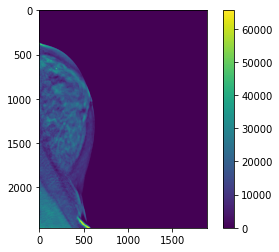

In [ ]:
print('size of return is ',img_data.shape)
plt.figure()
plt.imshow(img_data[0,:,:])
plt.colorbar()

In [ ]:
len(box_info)

1

In [ ]:
#
# Show the final DCM files found
#
show_boxes = 0
make_png = 1
if (show_boxes == 1):
    f1 = plt.figure(dpi=1200) #reuse the figure to avoid memory leak
    for patient_id in patient_data.keys():
        #do a pre-check to see if this has a bounding box
        for patient_uid in patient_data[patient_id].keys():
            for view_number in patient_data[patient_id][patient_uid].keys():
                counter = 0
                for dcm_file in patient_data[patient_id][patient_uid][view_number]:
                    #convert the views to the type used in the box csv file
                    view_type = match_view(view_number, view_map)

                    box_info=get_bounding_box(patient_id, patient_uid,view_type, boxes_rows)
                    dcm_full_file = os.path.join(upper_dir,patient_id, patient_uid, view_number,dcm_file)
                    print(dcm_full_file)
                    #img_data = dcmread_image(dcm_full_file,'0')
                    
                    #we will only print out the slices that have bounding boxes
                    number_matching_slices = np.shape(box_info)[0] #------NEEDS CHECKS
                    if (number_matching_slices <1):
                        print('!! no bounding box !!') #!! slice counting issue or no bounding box. skipping')
                        #print('---->',number_matching_slices, patient_id, view_type,box_info)
                    else:
                        dcm_full_file = os.path.join(upper_dir,patient_id, patient_uid, view_number,dcm_file)
                        img_data = dcmread_image(dcm_full_file,view_type) #'0')


                        for slices in range(0,number_matching_slices):
                            slice_number = int(box_info[slices][0])
                            print('Opening slice sequence#: ',slices, slice_number)

                            if (make_png == 1):
                                
                                plt.imshow(img_data[slice_number,:,:], cmap=plt.cm.bone)
                                #plt.imshow(ds.pixel_array[0,:,:], cmap=plt.cm.bone)
                                title_text = str(patient_id) + '_' + str(view_type)
                                plt.title(title_text)
                                plt.colorbar()
                                #plt.show()
                                
                                #### Draw annotation box
                                xcorner = int(box_info[slices][1])
                                ycorner = int(box_info[slices][2])
                                xwidth = int(box_info[slices][3])
                                yheight = int(box_info[slices][4])
                                rect = patches.Rectangle((xcorner,ycorner),xwidth,yheight,linewidth=2,edgecolor='r',facecolor='none')
                                # Get the current reference
                                ax = plt.gca()
                                # Add the patch to the Axes
                                ax.add_patch(rect)
                                plt.show()
                                ###

                                fname = str(patient_id) + '_' + str(view_number) + '_sequence' + str(slices) + 'slice_' + str(slice_number) + '.png'
                                save_filename = os.path.join(png_annotation_dir,fname)
                                plt.savefig(save_filename,dpi=1200)
                                time.sleep(0.5)
                                plt.cla()
                                plt.clf()
                                #del f1
                                #plt.close("all")
                                #ds = None #clear pydicom, memory leak if not
                        del img_data    #  img_data = None
                        gc.collect() #collect garbage
                    counter = counter + 1



#

In [12]:
image_save_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/DICOM2RAW/TRAINING' #matrix img data
#temporary for debugging

In [13]:
#
# STORE UNCOMPRESSED DICOM DATA TO NEW FILES
#
if (create_cancer_patches == 1):
    counter = 0
    start_index = -1
    for pcounter,patient_id in enumerate(patient_data.keys()):
        print('pcount at --->', pcounter)

        if (pcounter < start_index):
            #skip these
            continue

        #do a pre-check to see if this has a bounding box
        for patient_uid in patient_data[patient_id].keys():
            for view_number in patient_data[patient_id][patient_uid].keys():
                
                for dcm_file in patient_data[patient_id][patient_uid][view_number]:
                    #convert the views to the type used in the box csv file
                    view_type = match_view(view_number, view_map)

                    ### Assign Cancer Label name
                    study_id, cancer_status = get_cancer_label(patient_uid,'',label_rows)
                    #print('cancer status is ', cancer_status)
                    ###

                    dcm_full_file = os.path.join(upper_dir,patient_id, patient_uid, view_number,dcm_file)
                    print(dcm_full_file)
                    img_file_name = patient_id + '_' +study_id + '_' + view_type + '_' + cancer_status + '.pickle' 
                    img_file_pickle = os.path.join(image_save_dir,img_file_name)

                    #test to see if image already in directory
                    if (os.path.exists(img_file_pickle)):
                        #skip this one, as it's already done
                        print('---> File already converted')
                        continue

                    img_data = dcmread_image(dcm_full_file,view_type) #'0')
                    counter = counter + 1

                    #img_file_pickle = os.path.join(image_save_dir,str.upper(cancer_status),img_file_name)
                    pickle.dump(img_data, open( img_file_pickle, "wb" ),protocol=5 )

                    del img_data    #  img_data = None
                    gc.collect() #collect garbage
    

print('*** DONE CONVERTING IMAGE DATA ***')
print('# files converted: ', counter)

#

Streaming output truncated to the last 5000 lines.
---> File already converted
pcount at ---> 2376
DBT-S01873
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02029/01-01-2000-DBT-S01873-MAMMO screening digital bilateral-12633/11354.000000-89000/1-1.dcm
---> File already converted
DBT-S01873
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02029/01-01-2000-DBT-S01873-MAMMO screening digital bilateral-12633/11353.000000-56627/1-1.dcm
---> File already converted
DBT-S01873
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02029/01-01-2000-DBT-S01873-MAMMO screening digital bilateral-12633/11352.000000-12612/1-1.dcm
---> File already converted
DBT-S01873
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02029/01-01-2000-DBT-S01873-MAMMO screening digital bilateral-12633/11355.000000-16327/1-1.dcm
---> File already converted
pcount at ---

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


DBT-S03114
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02482/01-01-2000-DBT-S03114-MAMMO screening digital bilateral-71595/6300.000000-02942/1-1.dcm
DBT-S03114
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02482/01-01-2000-DBT-S03114-MAMMO screening digital bilateral-71595/6297.000000-12005/1-1.dcm
pcount at ---> 2765
DBT-S00495
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02481/01-01-2000-DBT-S00495-MAMMO SCREENING DIGITAL BIALTERAL-11464/5718.000000-27429/1-1.dcm
DBT-S00495
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02481/01-01-2000-DBT-S00495-MAMMO SCREENING DIGITAL BIALTERAL-11464/5717.000000-42528/1-1.dcm
DBT-S00495
/content/gdrive/My Drive/DBTex2/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P02481/01-01-2000-DBT-S00495-MAMMO SCREENING DIGITAL BIALTERAL-11464/5716.000000-61344/1-1.dcm
DBT-S00495
/con

KeyboardInterrupt: ignored

In [ ]:
print(img_file_pickle)
print(upper_dir)
print(image_save_dir)
tdir = '/content/gdrive/My Drive/DBTex2/DBTEX_PHASE2_WORKING/' #DICOM2RAW/'
!ls '/content/gdrive/My Drive/DBTex2/DBTEX_PHASE2_WORKING'
print(os.path.exists(tdir))
af = '/content/gdrive/My Drive/DBTex2/DBTEX_PHASE2_WORKING/DICOM2RAW/erase.pckl'
pickle.dump(img_data, open( af, "wb" ),protocol=5 )

In [ ]:
#get_bounding_box(patient_id, patient_uid,view_type, boxes_rows)
f = os.path.join(image_save_dir,'DBT-P04578_DBT-S01641_rcc_Normal.pickle')
print(f)
idata = pickle.load( open( f, "rb" ) )

In [ ]:
np.shape(idata)

In [ ]:
#find set that is causing memory issue
debug_file = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00122/01-01-2000-DBT-S02054-MAMMO diagnostic digital bilateral-19089/3941.000000-93960/1-1.dcm'

%time img_data = dcmread_image(debug_file,'0')
plt.figure()
plt.imshow(img_data[0,:,:])
plt.colorbar()


In [ ]:
print(img_data.size)
img_data.shape
81*2457*1996

In [ ]:
 '''
 ###
 ### Build links to dcm files
 ###
 print('upper dir = ',upper_dir)
 counter = 0
 patient_folder = {} #store dcm files
 for root, directories, filenames in os.walk(upper_dir): 
    #print('base is ', os.path.basename(directories))
    for directory in directories:
        #create dictionary entry for this directory. The files will be stored
        #within this
        patient_path = os.path.join(root, directory) #link to direct pt folder
        print('root, dir = ',root,patient_path)
        #for every directory found in the patient directory, get a listing of
        #files in each 
        patient_files = os.listdir(patient_path)
        for file in patient_files:
            if ('.dcm' in file):
                if (directory not in patient_folder.keys()):
                    patient_folder[directory] = []
                patient_folder[directory].append(patient_files)
    #for filename in filenames:  
    #    print('f= ',os.path.join(root,filename))
    #    counter = counter + 1
    #    if (counter > 10):
    #        break
    #if (counter > 10):
    #    break

In [ ]:
for ii in patient_folder.keys():
    print(ii)

In [ ]:
### Open dcm file
###
'''
from pydicom import dcmread
file = '/content/gdrive/My Drive/DBT_DATA/TEST_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00118/01-01-2000-DBT-S05386-MAMMO screening digital bilateral-70928/7697.000000-17471/1-1.dcm'


ds = dcmread(file)
print(ds.PatientName)
ds.file_meta.TransferSyntaxUID
plt.imshow(ds.pixel_array[0,:,:], cmap=plt.cm.bone) 


In [ ]:
'''
np.shape(ds.pixel_array)
ds_slice = ds.pixel_array[0,:,:]
plt.imshow(ds_slice, cmap=plt.cm.jet)
plt.colorbar()

In [ ]:
while True:pass